# **k-Nearest Neighbors**

This notebook looks to explore one of the most common machine learning models namely the k-nearest neighbors.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from sklearn.datasets import load_iris, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
sns.set_style('darkgrid')

## Iris Dataset

In [3]:
iris_data = load_iris()
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [4]:
iris_df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
iris_df['target'] = pd.Series(iris_data.target, name='target')
iris_df.shape

(150, 5)

### Data Understanding

In [5]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [6]:
iris_df.tail()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


In [7]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [8]:
iris_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sepal length (cm),150.0,5.843333,0.828066,4.3,5.1,5.80,6.4,7.9
sepal width (cm),150.0,3.057333,0.435866,2.0,2.8,3.00,3.3,4.4
petal length (cm),150.0,3.758000,1.765298,1.0,1.6,4.35,5.1,6.9
petal width (cm),150.0,1.199333,0.762238,0.1,0.3,1.30,1.8,2.5
target,150.0,1.000000,0.819232,0.0,0.0,1.00,2.0,2.0


In [9]:
iris_df.isna().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
target               False
dtype: bool

In [10]:
iris_df['target'].value_counts()

0    50
1    50
2    50
Name: target, dtype: int64

The species of iris are evenly distributed across the Iris dataset.

### Splitting Data

Since the species are evenly distributed. Unlike regular splitting, I want to utilize `stratify` from `train_test_split` so that the training data is unbiased or in other words, the species are evenly distributed across our training data and test data.

In [11]:
X = iris_df.drop('target', axis=1)
y = iris_df['target']
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y.to_numpy(),
                                                    test_size=.2,
                                                    random_state=42,
                                                    stratify=y)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_test: {y_test.shape}')

Shape of X_train: (120, 4)
Shape of X_test: (30, 4)
Shape of y_train: (120,)
Shape of y_test: (30,)


In [12]:
np.bincount(y_train)

array([40, 40, 40])

In [13]:
np.bincount(y_test)

array([10, 10, 10])

All good to go.

### Modeling the Classifier

In [14]:
class KNeighborsClassifier:

  def __init__(self, n_neighbors, p=1, metric='euclidean'):
    self.n_neighbors = n_neighbors
    self.p = p
    self.metric = metric

  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

  def compute_distance(self, a, b):
    if self.metric == 'euclidean':
      return np.sqrt(np.sum((a - b) ** 2)) ** (1 / 2)
    elif self.metric == 'manhattan':
      return np.sum(abs(a - b))
    elif self.metric == 'minkowski':
      return np.sum(abs(a - b) ** self.p) ** (1 / self.p)
    elif self.metric == 'hamming':
      return sum(n != m for n, m in zip(a, b))
  
  def predict(self, X_test):
    y_pred = []
    for test_data in X_test:
      distances = []
      for train_data in X_train:
        distances.append(self.compute_distance(test_data, train_data))
      
      distances = np.array(distances)
      sorted_distances = np.argsort(distances)[:self.n_neighbors]
      neighbor_labels = self.y_train[sorted_distances]
      y_pred.append(mode(neighbor_labels).mode[0])
      
    return y_pred

### Predict with Classifier

A baseline model is a nice way to start with the experiment.

In [15]:
baseline_model = KNeighborsClassifier(n_neighbors=2)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
print(f'Baseline model accuracy score: {accuracy_score(y_test, y_pred)}')

Baseline model accuracy score: 0.9333333333333333


Actually, the baseline model seems to be very good already. But we can experiment further since there are still room for improvement.

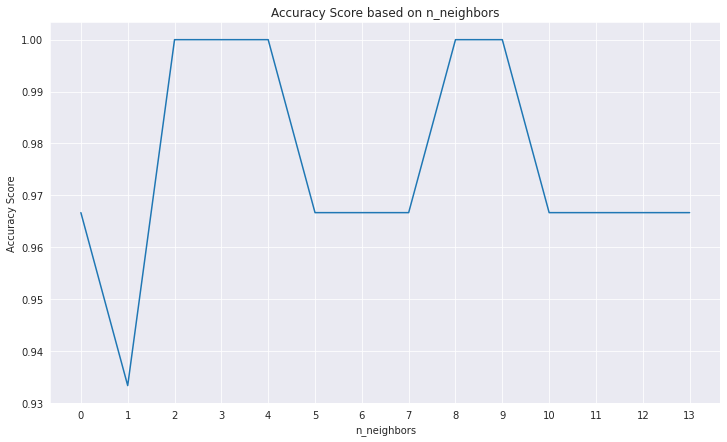

In [16]:
model_scores = []
for n_neighbors in range(1, 15):
  model = KNeighborsClassifier(n_neighbors=n_neighbors)
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test) 
  model_scores.append(accuracy_score(y_test, y_pred))

fig, ax = plt.subplots(figsize=(12, 7))
sns.lineplot(data=model_scores, ax=ax).set_title(f'Accuracy Score based on n_neighbors')
ax.set(xlabel='n_neighbors', ylabel='Accuracy Score')
plt.xticks(np.arange(0, len(model_scores), 1))

plt.show()

I think the more neighbors to compare with and the better the accuracy score is the number worth trying. In this case, it is 9.

In [17]:
model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')

Accuracy score: 1.0


In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [19]:
def plot_confusion_matrix(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(6, 6))
  sns.heatmap(confusion_matrix(y_test, y_pred),
              annot=True,
              cbar=False,
              cmap='flare').set_title('Confusion Matrix')
  
  ax.set(xlabel='Predicted Label', ylabel='Test Label')

  plt.show()

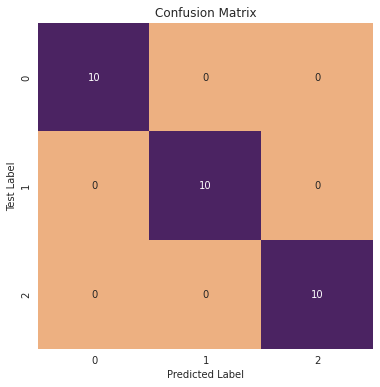

In [20]:
plot_confusion_matrix(y_test, y_pred)

Our model seems perfect for now. For future experiments, I can also try to implement validation sets into the training process and maybe a cross validation to make sure our model is that good.

### Experimenting other Distance Measures

In [21]:
n_neighbors = 9
models = {
    'hamming': KNeighborsClassifier(n_neighbors=n_neighbors, metric='hamming'),
    'manhattan': KNeighborsClassifier(n_neighbors=n_neighbors, metric='manhattan'),
    'minkowski': KNeighborsClassifier(n_neighbors=n_neighbors, p=3, metric='minkowski')
}

y_preds = {}
for metric, model in models.items():
  model.fit(X_train, y_train)
  y_preds[metric] = model.predict(X_test)

**Hamming Distance**

              precision    recall  f1-score   support

           0       0.71      1.00      0.83        10
           1       0.86      0.60      0.71        10
           2       0.89      0.80      0.84        10

    accuracy                           0.80        30
   macro avg       0.82      0.80      0.79        30
weighted avg       0.82      0.80      0.79        30



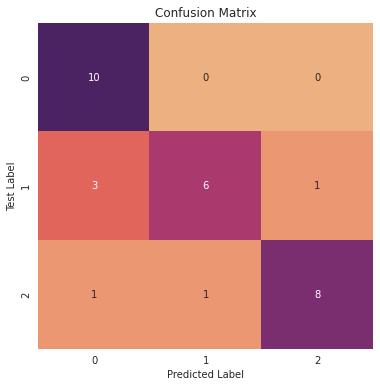

In [22]:
print(classification_report(y_test, y_preds['hamming']))
plot_confusion_matrix(y_test, y_preds['hamming'])

**Manhattan Distance**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.90      0.90      0.90        10
           2       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30



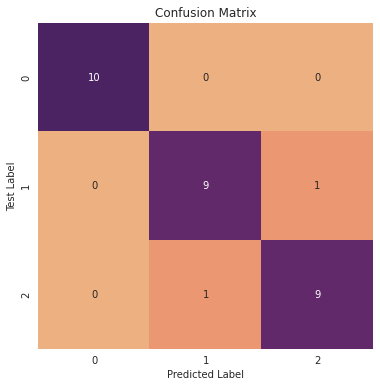

In [23]:
print(classification_report(y_test, y_preds['manhattan']))
plot_confusion_matrix(y_test, y_preds['manhattan'])

**Minkowski Distance**

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



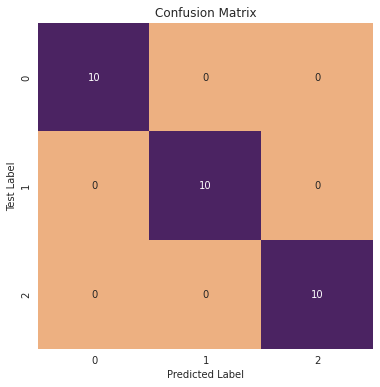

In [24]:
print(classification_report(y_test, y_preds['minkowski']))
plot_confusion_matrix(y_test, y_preds['minkowski'])

Other distance measures are not far off the mark compared to the euclidean distance measure except for the hamming distance. Hamming distance might work better on another dataset with different type of features, not this dataset. Overall, the model performs very well throughout the experimentation on Iris dataset.

## Boston Dataset

In [25]:
names = ['CRIM', 
         'ZN', 
         'INDUS', 
         'CHAS', 
         'NOX', 
         'RM', 
         'AGE', 
         'DIS', 
         'RAD', 
         'TAX', 
         'PTRATIO', 
         'B', 
         'LSTAT', 
         'MEDV']

housing_df = pd.read_csv('https://raw.githubusercontent.com/dzniel/binus-machine-learning-course/main/datasets/housing.csv', 
                         header=None, 
                         sep='\s+', 
                         names=names)

housing_df.shape

(506, 14)

### Data Understanding

In [26]:
housing_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


In [27]:
housing_df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48,22.0
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273.0,21.0,396.90,7.88,11.9


In [28]:
housing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [29]:
housing_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


In [30]:
housing_df.isna().any()

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
MEDV       False
dtype: bool

### Splitting Data

In [31]:
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(), 
                                                    y.to_numpy(), 
                                                    test_size=.2, 
                                                    random_state=42)
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (404, 13)
y_train shape: (404,)
X_test shape: (102, 13)
y_test shape: (102,)


### Modeling the Regressor

In [32]:
class KNeighborsRegressor:

  def __init__(self, n_neighbors):
    self.n_neighbors = n_neighbors

  def fit(self, X_train, y_train):
    self.X_train = X_train
    self.y_train = y_train

  def compute_distance(self, a, b, p=2):
    return np.sqrt(np.sum((a - b) ** p)) ** (1 / p)

  def predict(self, X_test):
    y_pred = []
    for test_data in X_test:
      distances = []
      for train_data in X_train:
        distances.append(self.compute_distance(test_data, train_data))
      
      distances = np.array(distances)
      sorted_distances = np.argsort(distances)[:self.n_neighbors]
      neighbor_prices = self.y_train[sorted_distances]
      y_pred.append(np.mean(neighbor_prices))
      
    return y_pred

  def score(self, y_test, y_pred):
    print('MAE score:', mean_absolute_error(y_test, y_pred))
    print('MSE score:', mean_squared_error(y_test, y_pred))
    print('RMSE score:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R2 score:', r2_score(y_test, y_pred))

### Predict with Regressor

In [33]:
baseline_model = KNeighborsRegressor(n_neighbors=2)
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)
baseline_model.score(y_test, y_pred)

MAE score: 3.8990196078431367
MSE score: 32.59946078431373
RMSE score: 5.709593749498621
R2 score: 0.5554646251776688


Since the boston dataset relatively have smaller price values, the losses also appear to be smaller. But the R2 score speaks for itself. The baseline model predicts as if its just guessing.

To get the model to do better, a well prepared and cleaned data is necessary such as removing outliers, dropping low-correlated features, and features scaling.

### Removing Outliers

In [34]:
def visualize_outliers(df):
  fig, axes = plt.subplots(nrows=7, 
                           ncols=2,
                           figsize=(12, 25))
  
  axes = axes.flatten()
  index = 0
  for x in df.columns:
    sns.boxplot(x=x, data=df, ax=axes[index])
    index += 1

  plt.show()

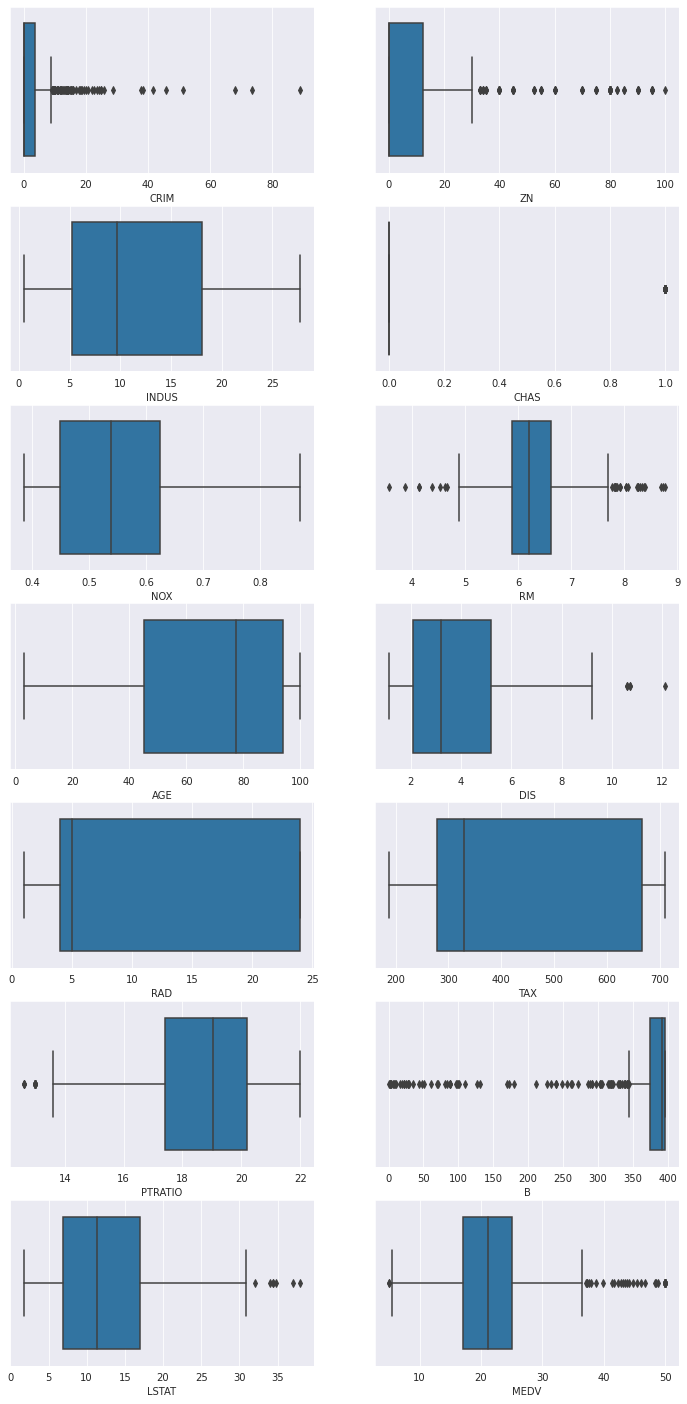

In [35]:
visualize_outliers(housing_df)

The most obvious one to start with is the outliers on our target data which is `MEDV`.

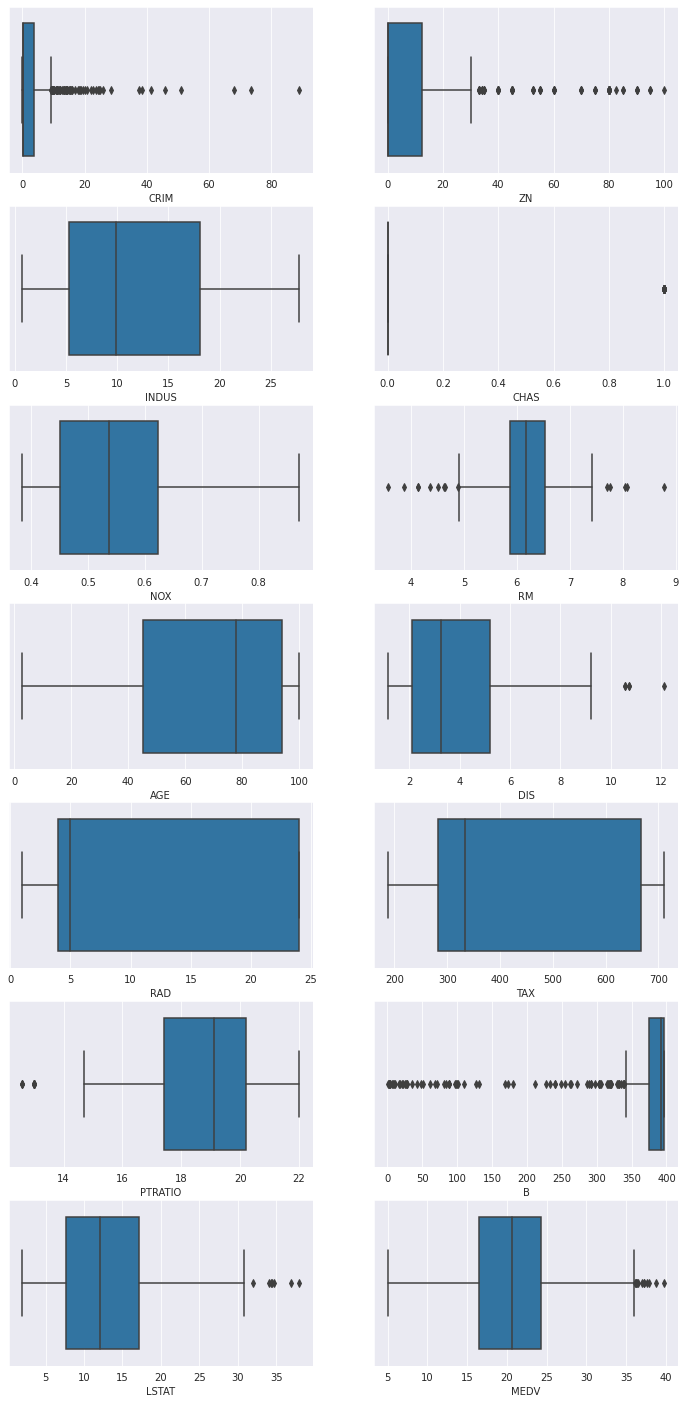

In [36]:
housing_df = housing_df[housing_df.MEDV <= 40]
visualize_outliers(housing_df)

### Dropping Low-Correlated Features

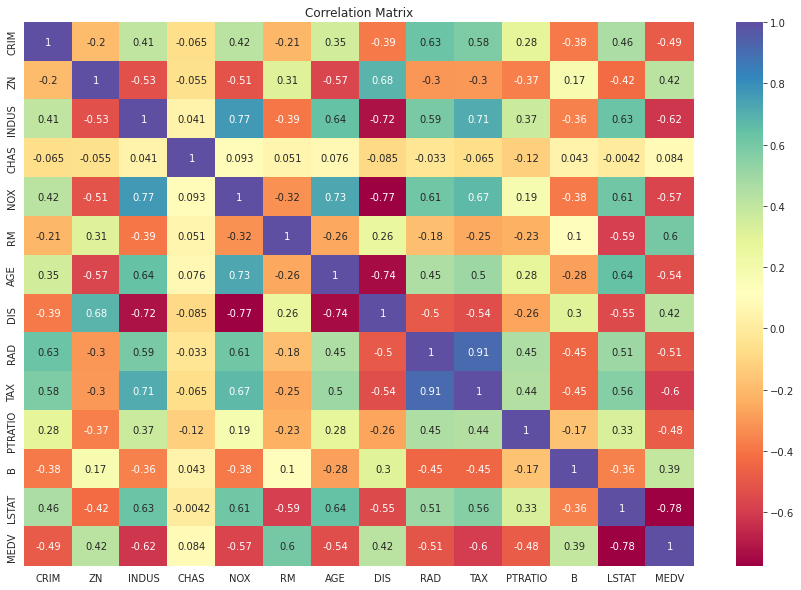

In [37]:
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(housing_df.corr(), 
            cmap='Spectral', 
            annot=True, 
            ax=ax).set_title('Correlation Matrix')

plt.show()

From the correlation matrix, some features we might consider dropping are:
1. `CRIM`
2. `ZN`
3. `RM`
4. `DIS`
5. `PTRATIO`
6. `B`

In [38]:
housing_df.drop(['CRIM', 'ZN', 'RM', 'DIS', 'PTRATIO', 'B'],
                axis=1,
                inplace=True)

housing_df.shape

(475, 8)

### Remove Outliers in Remaining Features

In [39]:
def plot_distribution(df):
  fig, axes = plt.subplots(nrows=8, 
                           figsize=(12, 30))
  
  index = 0
  for x in df.columns:
    sns.boxplot(x=x, data=df, ax=axes[index])
    index += 1

  plt.show()

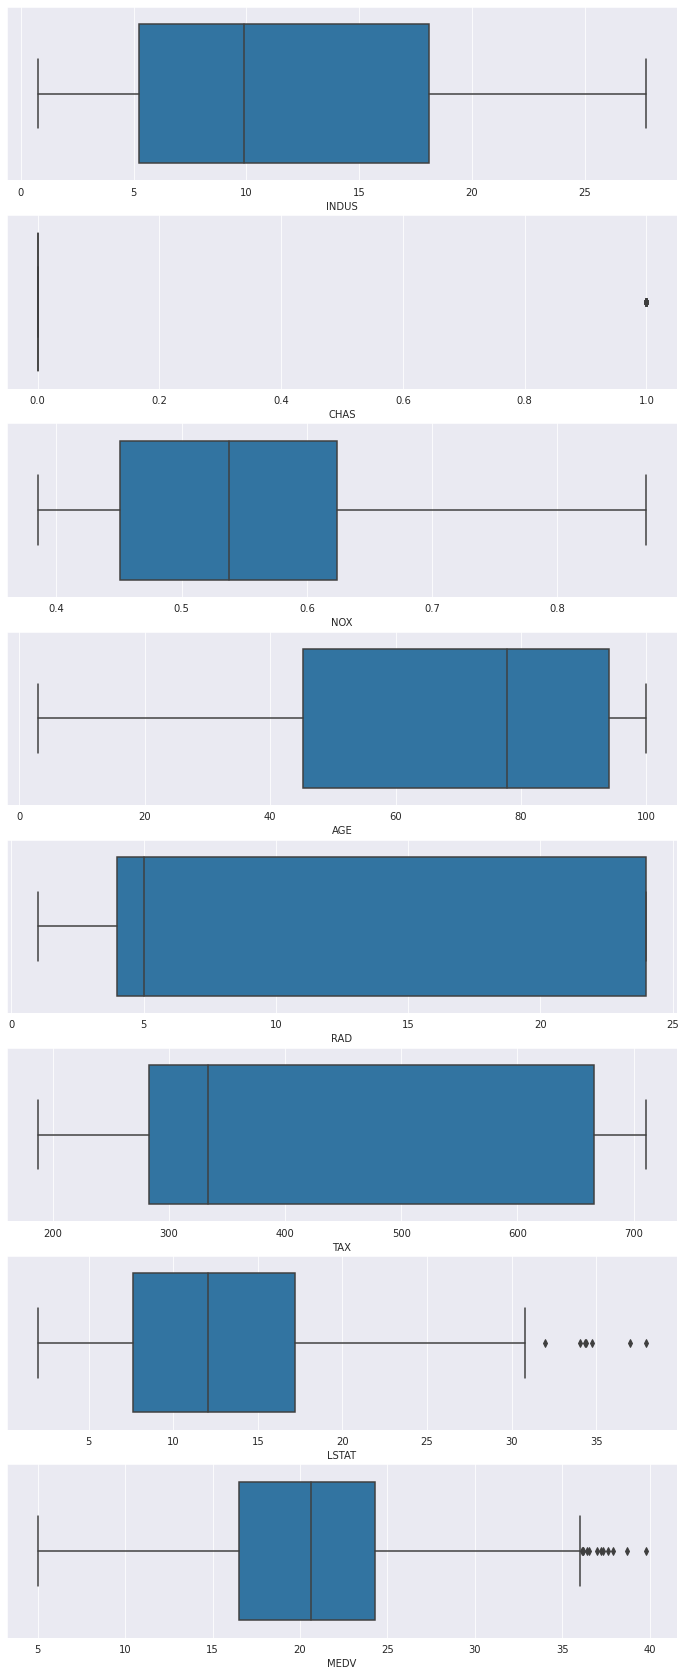

In [40]:
plot_distribution(housing_df)

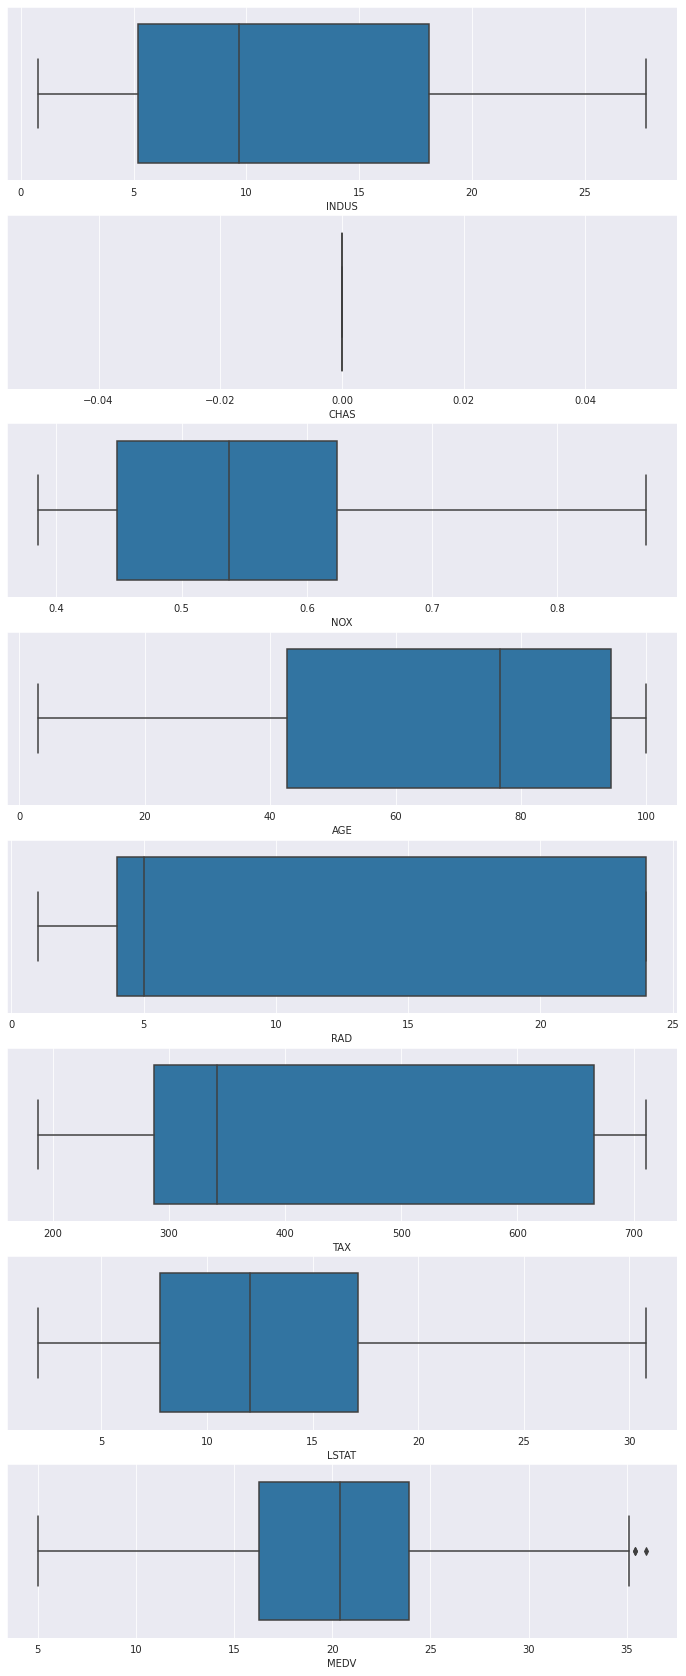

In [41]:
q1 = housing_df.quantile(0.25)
q3 = housing_df.quantile(0.75)
interquantile = q3 - q1
housing_df = housing_df[~((housing_df < (q1 - 1.5 * interquantile)) | (housing_df > (q3 + 1.5 * interquantile))).any(axis=1)]
plot_distribution(housing_df)

### Splitting Data

In [42]:
X = housing_df.drop('MEDV', axis=1)
y = housing_df['MEDV']
X_train, X_test, y_train, y_test = train_test_split(X.to_numpy(),
                                                    y.to_numpy(), 
                                                    test_size=.2, 
                                                    random_state=42)

print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

X_train shape: (342, 7)
y_train shape: (342,)
X_test shape: (86, 7)
y_test shape: (86,)


### Features Scaling

In [43]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [44]:
model = KNeighborsRegressor(n_neighbors=9)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
model.score(y_test, y_pred)

MAE score: 2.527390180878552
MSE score: 10.333697961527418
RMSE score: 3.2146069684375753
R2 score: 0.7017895308553688


The model score is much better than the baseline model before despite there is still much room for improvement.

In [45]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred': np.round(y_pred, 1)
})

results_df

,y_test,y_pred
0,21.2,20.4
1,20.0,20.4
2,34.9,24.4
3,14.5,19.1
4,10.5,11.5
...,...,...
81,14.1,15.2
82,23.3,25.9
83,16.2,17.0
84,13.9,16.8


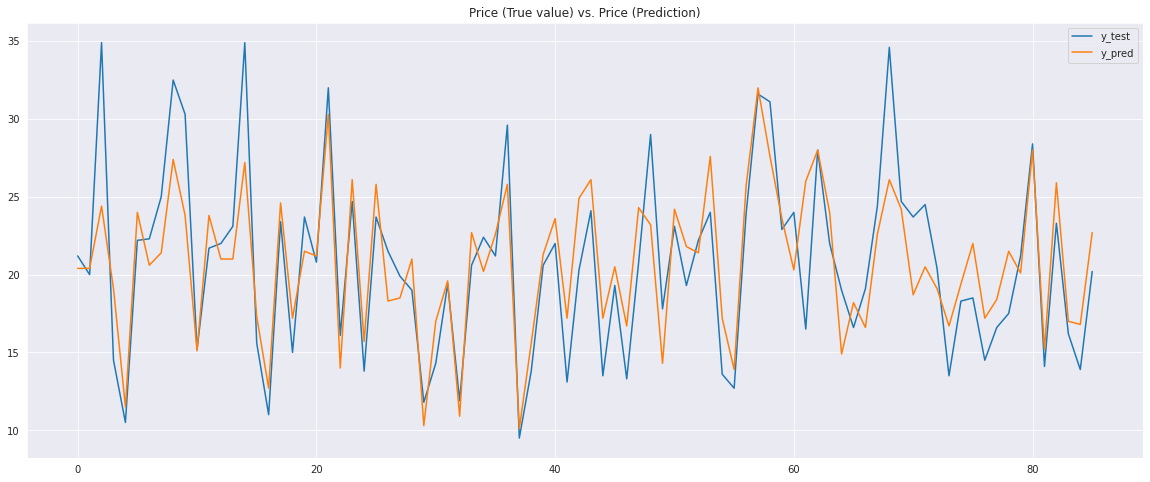

In [46]:
plt.figure(figsize=(20, 8))
plt.title('Price (True value) vs. Price (Prediction)')
sns.lineplot(x=np.arange(0, 86), y=results_df['y_test'], label='y_test')
sns.lineplot(x=np.arange(0, 86), y=results_df['y_pred'], label='y_pred')
plt.ylabel('')

plt.show()